# Etapa 1: Importação das bibliotecas

In [3]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [5]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [6]:
path = './trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [7]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [8]:
train_data = pd.read_csv('./trainingandtestdata/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [9]:
train_data.shape

(1600000, 6)

In [10]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
train_data.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [12]:
train_data.sentiment.unique()

array([0, 4], dtype=int64)

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


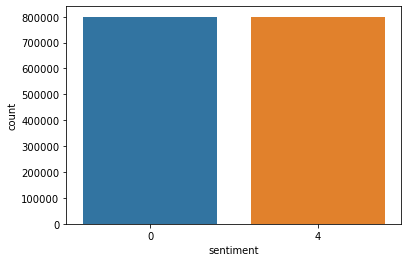

In [13]:
sns.countplot(train_data.sentiment);

In [15]:
test_data = pd.read_csv("./trainingandtestdata/test.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

In [16]:
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [17]:
test_data.shape

(498, 6)

In [18]:
test_data.sentiment.unique()

array([4, 0, 2], dtype=int64)

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


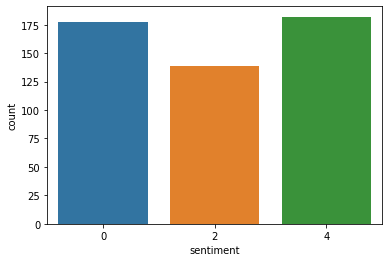

In [19]:
sns.countplot(test_data.sentiment);

## Pré-processamento

### Limpeza

In [20]:
data = train_data

In [21]:
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [22]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [23]:
X = data.iloc[:, 1].values

In [24]:
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [25]:
X.shape

(1600000,)

In [26]:
type(X)

numpy.ndarray

In [27]:
y = data.iloc[:, 0].values
y

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [28]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [29]:
X.shape

(240000,)

In [30]:
y.shape

(240000,)

In [31]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4], dtype=int64), array([120000, 120000], dtype=int64))

In [32]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [33]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [34]:
text = clean_tweets(text)
text

' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [38]:
nlp = sp.load('en_core_web_sm')
nlp

In [39]:
stop_words = sp.lang.en.STOP_WORDS

In [40]:
print(stop_words)

{'amongst', 'part', 'also', 'it', 'again', 'there', 'fifteen', "n't", 'two', 'our', 'six', 'bottom', 'an', 'noone', 'after', 'three', 're', 'being', 'under', 'about', 'either', '‘re', 'do', 'neither', 'whereas', 'twelve', 'though', 'into', 'over', 'see', 'afterwards', 'top', 'my', 'otherwise', '’ve', 'ours', 'twenty', 'was', 'without', 'of', 'ten', 'using', 'everyone', 'seemed', 'something', 'wherein', 'did', 'any', 'various', 'who', 'former', 'his', 'this', 'during', "'ve", 'back', 'name', 'ca', 'him', 'until', 'put', 'anywhere', 'n‘t', 'latterly', 'and', 'show', "'s", 'further', 'often', 'the', 'became', 'had', 'hereafter', 'whereby', 'nevertheless', 'across', 'whom', 'therefore', 'herein', 'whole', 'yourselves', '‘m', 'moreover', 'whenever', 'or', 'you', 'himself', 'just', 'last', 'due', 'sometime', 'well', 'below', 'whose', 'sixty', 'your', 'becoming', 'sometimes', 'doing', 'somewhere', 'less', 'once', 'becomes', 'where', 'take', 'thereby', 'beside', 'them', 'whence', 'everything',

In [41]:
len(stop_words)

326

In [42]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [44]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [46]:
text2 = clean_tweets2(text)
text2

'  awww s bummer shoulda got david carr day d'

In [47]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

In [48]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

  follow
things
raining dull day
  aww sophieee lucky bum wish hands preordered d wait week shipping ...
tell hmm
oh wish atp documentary screening ifi tomorrow night followed dj set barry hogan
sunburn
  ignite mtv brasil que legal awesome let know need help lived brasil years speak portuguese ...
best feeling world clients telling amazing u boss
  jessicab xx kind yeah strawberries taste sweet


In [49]:
data_labels = y

In [50]:
data_labels[data_labels == 4] = 1

In [51]:
data_labels

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [52]:
np.unique(data_labels)

array([0, 1], dtype=int64)

### Tokenização

In [53]:
2**16

65536

In [54]:
import math
math.pow(2, 16)

65536.0

In [55]:
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [56]:
tokenizer.vocab_size

52618

In [57]:
print(tokenizer.subwords)

['  ', 's_', 'm_', 't_', ' ... ', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'don_', 'u_', ' ...', 'work_', 'today_', 'know_', 'time_', 'new_', 'll_', 'think_', 'want_', 'oh_', 'lol_', 'need_', 'thanks_', 'hope_', 'night_', 've_', 'home_', 'miss_', 'great_', 'd_', 'feel_', ' .... ', 'wish_', 'day', 'twitter_', 'lol', 'na_', 'morning_', 'happy_', 'gon_', 'getting_', 'today', 'bad_', 'watching_', 'haha_', 'sorry_', 'tomorrow_', ' ..', 'didn_', 'nice_', 'way_', 'come_', 'sad_', 'fun_', 'yeah_', 'sleep_', 'wait_', 'work', 'n_', 'right_', 'hey_', 'hate_', 'people_', 'better_', 'bed_', 'little_', 'tonight_', 'yes_', 'school_', 'wanna_', 'y_', 'having_', 'week_', 'long_', 'best_', 'thank_', 'time', 'let_', 'awesome_', 'days_', 'watch_', 'ur_', 'ok_', 'feeling_', 'working_', 'o_', 'won_', 'good', 'ready_', 'sure_', 'looking_', 'night', 'tomorrow', 'r_', 'e_', 'find_', 'man_', 'look_', 'went_', 'life_', 'weekend_', 'trying_', 'tired_', 'thing_', 'pretty_', 'maybe_', 'om

In [58]:
ids = tokenizer.encode('i am happy')
ids

[275, 4157, 372]

In [59]:
text = tokenizer.decode(ids)
text

'i am happy'

In [60]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [61]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[333, 2890]
[1, 1560, 7748, 2488, 11773, 11808, 110, 134]
[1, 3, 702, 2, 200, 276, 6634, 9338]
[15761, 1421, 1113, 941, 3341, 68, 6, 668, 28, 1607, 52473]
[1, 35640, 66, 1059, 24399, 173, 569, 410]
[23823, 836, 564, 2295, 1790, 9201, 5359, 16038, 17434, 5617]
[1, 7118, 3, 20123, 52394, 33, 1273, 18430]
[922, 1069, 3251, 2291, 16393, 52394, 24, 14, 4, 23, 2, 11, 782, 69, 63]
[19827, 44933, 7641, 194, 4, 2000, 37, 9847, 18630, 29799, 6586]
[1, 323, 96, 689, 249, 8710, 2, 55, 6920, 2, 43277, 52463]


### Padding

In [62]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

43

In [63]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [64]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[    1   432   236  2806  2806  2806 27399 52394   221     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[   33   222    59 12946     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[  1  14   4 171   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[   1 4950  716 9996   68 6168 2109    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[    1   549  6988 41854 52394   502 13173   611   117   923     0     0
     

### Divisão da base de dados em treinamento e teste



In [65]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [66]:
train_inputs[0]

array([    1,    19, 18033,   127,   441,    65, 15893,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [67]:
train_inputs.shape

(168000, 43)

In [68]:
train_labels.shape

(168000,)

In [69]:
test_inputs.shape

(72000, 43)

In [70]:
test_labels.shape

(72000,)

# Etapa 3: Construção do modelo

In [71]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Etapa 4: Treinamento

## Configuração dos parâmetros

In [72]:
vocab_size = tokenizer.vocab_size
vocab_size

52618

In [73]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [74]:
dropout_rate = 0.2
nb_epochs = 5

## Treinamento

In [75]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [76]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [78]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
2363/2363 [==============================] - 265s 111ms/step - loss: 0.5008 - accuracy: 0.7522 - val_loss: 0.4686 - val_accuracy: 0.7729
Epoch 2/5
2363/2363 [==============================] - 253s 107ms/step - loss: 0.3595 - accuracy: 0.8407 - val_loss: 0.5109 - val_accuracy: 0.7646
Epoch 3/5
2363/2363 [==============================] - 222s 94ms/step - loss: 0.1871 - accuracy: 0.9223 - val_loss: 0.6943 - val_accuracy: 0.7455
Epoch 4/5
2363/2363 [==============================] - 223s 94ms/step - loss: 0.0983 - accuracy: 0.9589 - val_loss: 1.0735 - val_accuracy: 0.7440
Epoch 5/5
2363/2363 [==============================] - 224s 95ms/step - loss: 0.0670 - accuracy: 0.9717 - val_loss: 1.2525 - val_accuracy: 0.7325


'./ckpt-1'

# Etapa 5: Avaliação do modelo

## Avaliação

In [79]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

1125/1125 [==============================] - 6s 5ms/step - loss: 1.2609 - accuracy: 0.7287
[1.2608619928359985, 0.7286666631698608]


In [80]:
y_pred_test = Dcnn.predict(test_inputs)

In [81]:
y_pred_test

array([[1.0000000e+00],
       [2.0453334e-04],
       [7.2488189e-04],
       ...,
       [8.4332287e-01],
       [1.0141912e-01],
       [1.7393425e-07]], dtype=float32)

In [82]:
y_pred_test = (y_pred_test > 0.5)

In [83]:
y_pred_test

array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [84]:
test_labels

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [85]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[26892,  9108],
       [10428, 25572]], dtype=int64)

<AxesSubplot:>

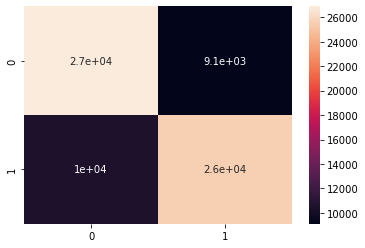

In [86]:
sns.heatmap(cm, annot=True)

In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

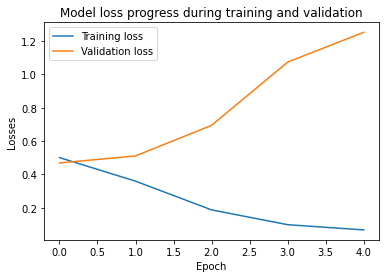

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

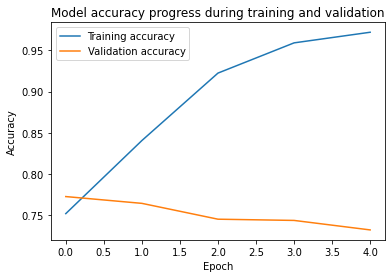

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Previsões

In [90]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[275, 67, 4017]

In [91]:
Dcnn(np.array([text]), training=False).numpy()

array([[8.652635e-05]], dtype=float32)